In [1]:
from fastai.vision import *
from fastai.vision.data import *
import numpy as np 
import pandas as pd
import tensorflow as tf 
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

In [2]:
from fastai.widgets import *

In [2]:
labels = ['0','1','2','3','4','5']
classes = labels

In [3]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
2,5,1,5,4
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

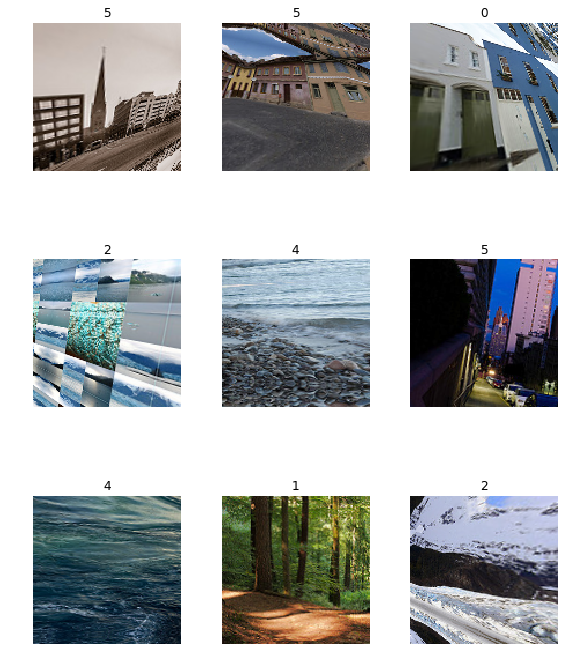

In [4]:
data.show_batch(rows=3, figsize=(8,10))

In [5]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [4]:
learn = create_cnn(data,models.resnet50,metrics=[error_rate, accuracy])

c:\users\rohit\virtualenv\lib\site-packages\fastai\vision\learner.py:105: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")


In [5]:
learn.fit_one_cycle(8)

In [6]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

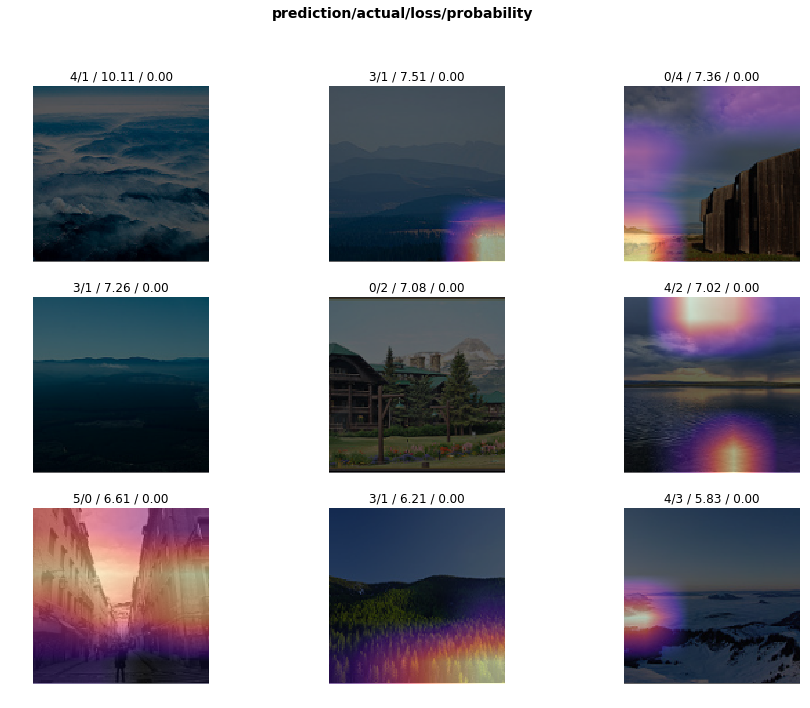

In [7]:
interp.plot_top_losses(9, figsize=(15,11))

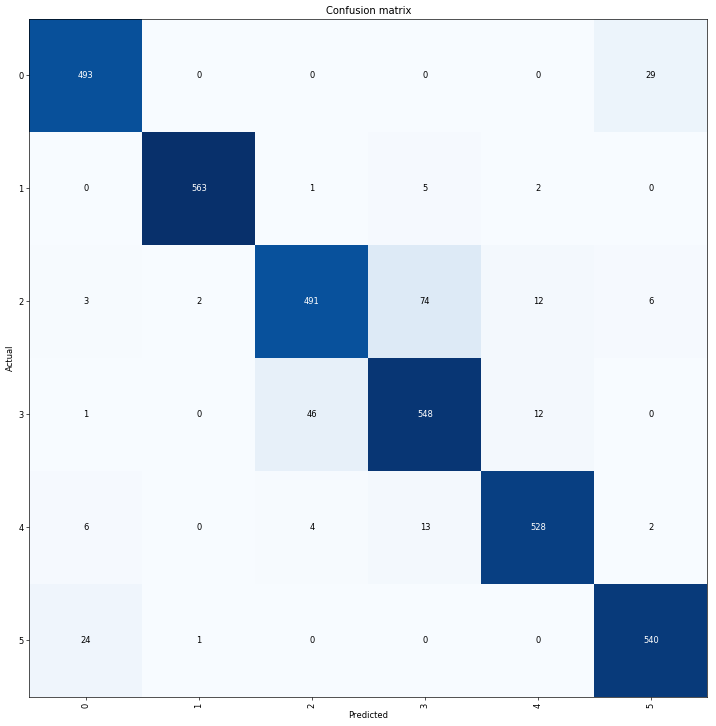

In [8]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [9]:
interp.most_confused(min_val=5)

[(2, 3, 74),
 (3, 2, 46),
 (0, 5, 29),
 (5, 0, 24),
 (4, 3, 13),
 (2, 4, 12),
 (3, 4, 12),
 (2, 5, 6),
 (4, 0, 6),
 (1, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


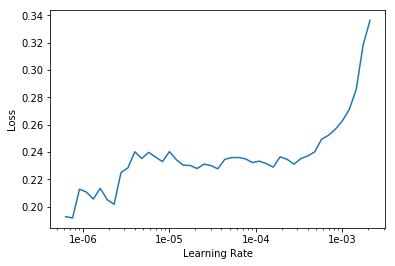

In [10]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.save('stage1-resnet50-normal')

# Stage 2

In [5]:
learn.load('stage1-resnet50-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,2,2,4,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,5e-6))

In [7]:
learn.save('stage2-resnet50-normal')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

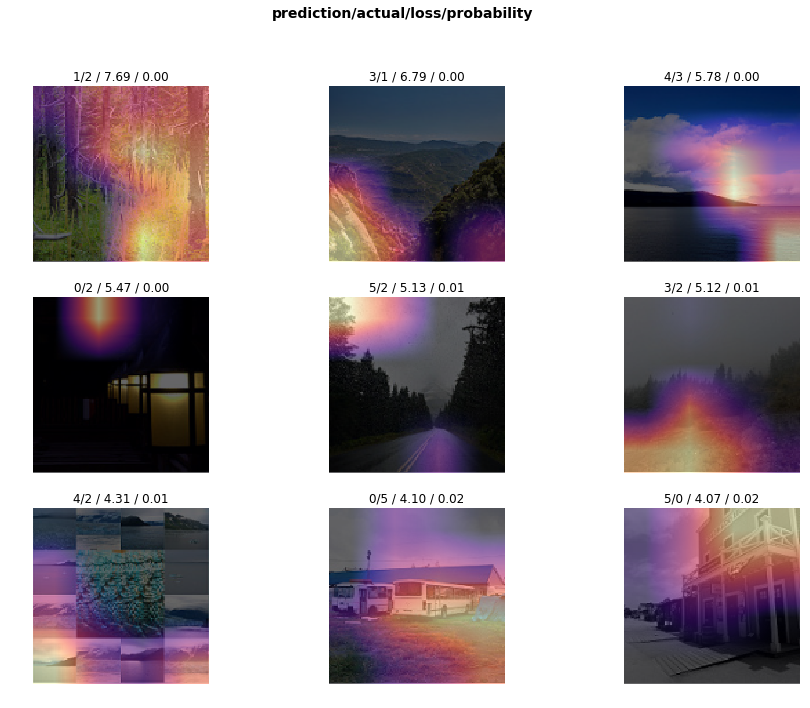

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

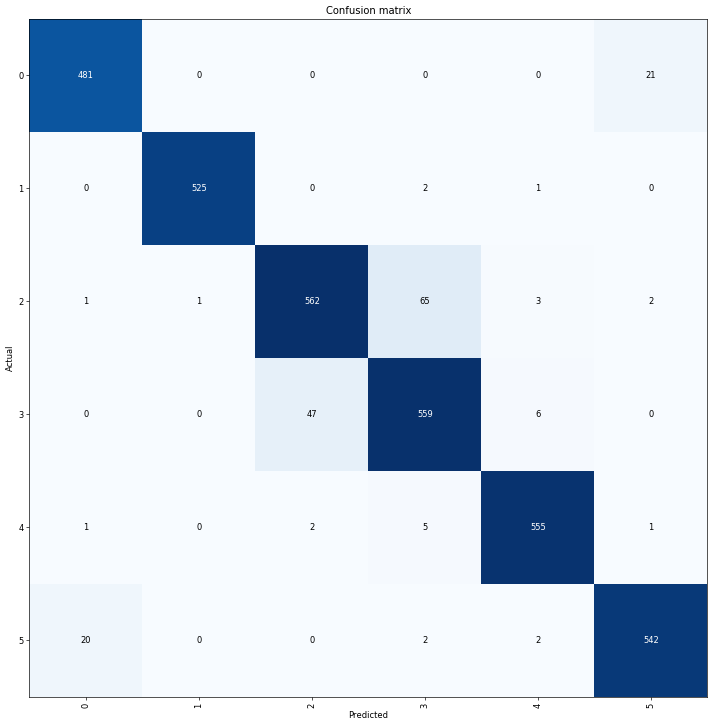

In [10]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[(2, 3, 65), (3, 2, 47), (0, 5, 21), (5, 0, 20), (3, 4, 6), (4, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


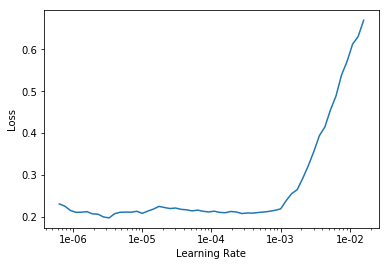

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
import gc 
gc.collect()

6382

In [16]:
path='train-scene/train'
test = pd.read_csv('test.csv')

In [17]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999467
1      5.jpg      0     0.999785
2      6.jpg      4     0.999918
3     11.jpg      2     0.788692
4     14.jpg      5     0.983365

In [18]:
uncertain = answer.loc[answer['probability']<0.5].count()
print(uncertain)

image_name     50
label          50
probability    50
dtype: int64


In [19]:
answer.to_csv('stage2_resnet50_normal.csv')

# Stage 3

In [5]:
learn.load('stage2-resnet50-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
2,5,1,5,4
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
learn.fit_one_cycle(4, max_lr=slice(1e-6,1e-4))

In [7]:
learn.save('stage3-resnet50-normal')

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

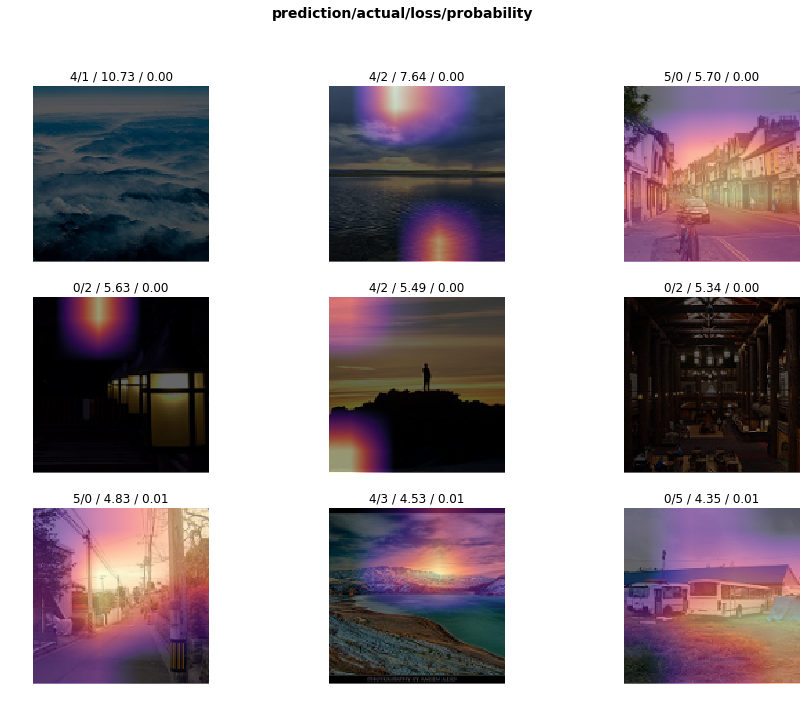

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

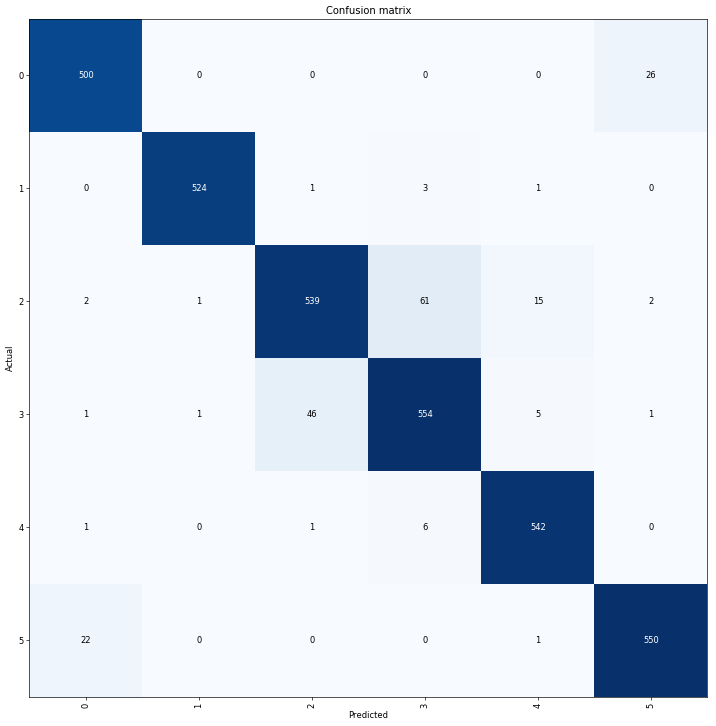

In [10]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[(2, 3, 61),
 (3, 2, 46),
 (0, 5, 26),
 (5, 0, 22),
 (2, 4, 15),
 (4, 3, 6),
 (3, 4, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


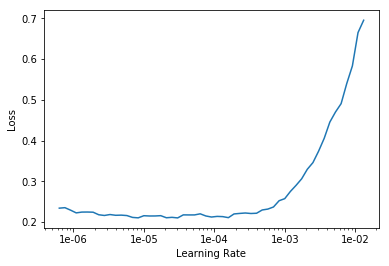

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
path = 'train-scene/train'
print(path)

train-scene/train


In [14]:
test = pd.read_csv('test.csv')

In [15]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
answer.to_csv('stage3_resnet50_normal.csv')

In [16]:
import gc
gc.collect()

6455

In [17]:
answer.head()

image_name  label  probability
0      3.jpg      5     0.999556
1      5.jpg      0     0.999723
2      6.jpg      4     0.999915
3     11.jpg      2     0.743482
4     14.jpg      5     0.985260

In [18]:
answer.probability.sum() / answer.probability.count()

0.9370658669124285

In [19]:
uncertain = answer.loc[answer['probability']<0.5]
uncertain.count()

image_name     54
label          54
probability    54
dtype: int64

# Stage 4

In [54]:
learn.fit_one_cycle(5, max_lr=slice(1e-6))

In [55]:
learn.save('stage4')

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

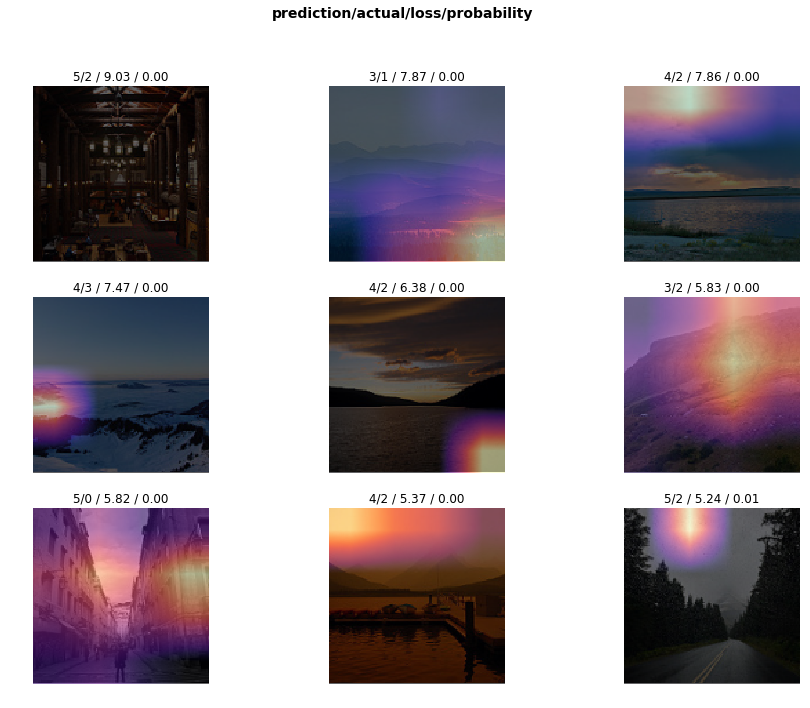

In [58]:
interp.plot_top_losses(9, figsize=(15,11))

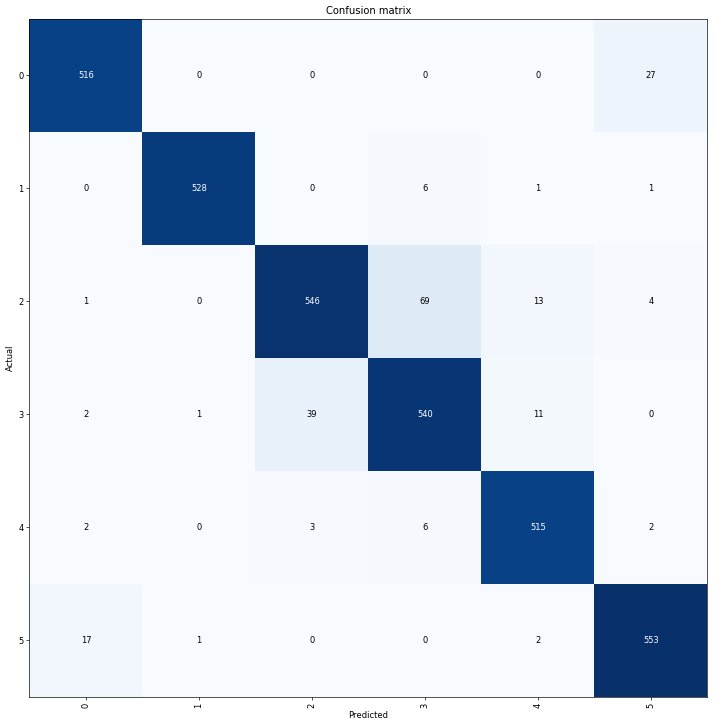

In [59]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [60]:
interp.most_confused(min_val=5)

[(2, 3, 69),
 (3, 2, 39),
 (0, 5, 27),
 (5, 0, 17),
 (2, 4, 13),
 (3, 4, 11),
 (1, 3, 6),
 (4, 3, 6)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


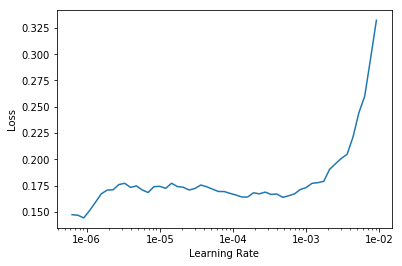

In [27]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
path = 'train-scene/train'
print(path)

train-scene/train


In [62]:
test = pd.read_csv('test.csv')

In [63]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
answer.to_csv('submission.csv')

In [64]:
import gc
gc.collect()

18295

# Densenet

In [1]:
from fastai.vision import *

In [2]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.1,max_warp=0.5,max_lighting=0.3,p_lighting = 0.5 )
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))

In [3]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,1,3
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

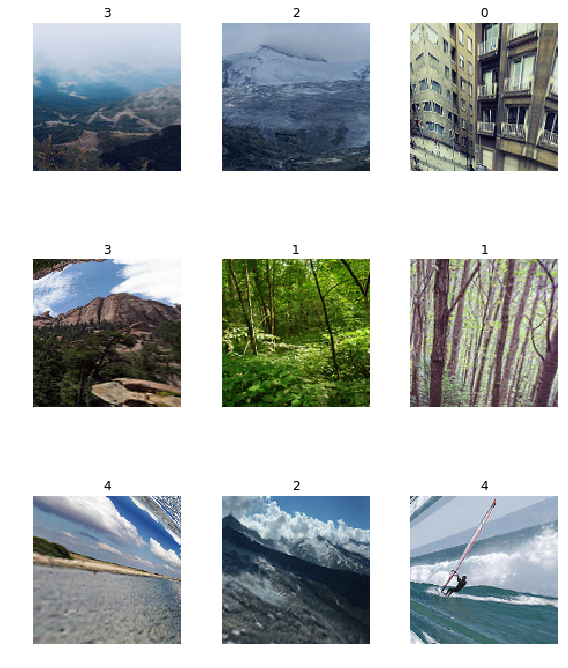

In [4]:
data.show_batch(rows=3, figsize=(8,10))

In [5]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [6]:
learn = cnn_learner(data,models.densenet121,metrics=[error_rate, accuracy])

c:\users\rohit\virtualenv\lib\site-packages\torchvision\models\densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [7]:
learn.fit_one_cycle(5)

In [8]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

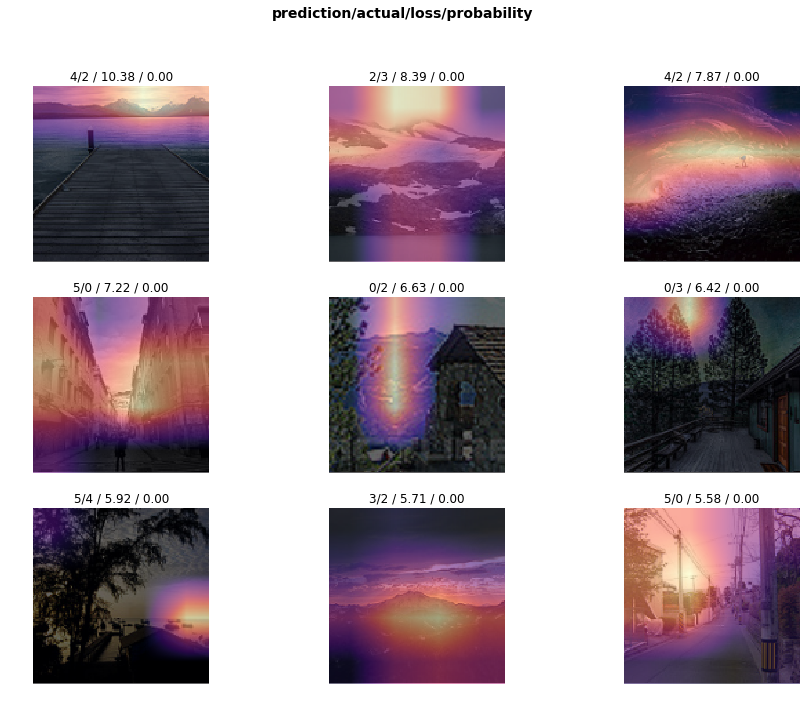

In [9]:
interp.plot_top_losses(9, figsize=(15,11))

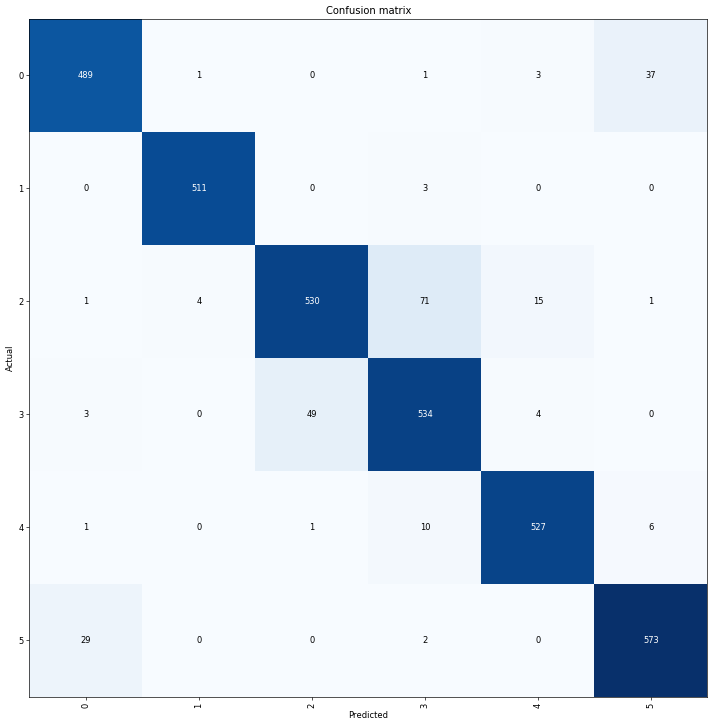

In [10]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [11]:
interp.most_confused(min_val=5)

[(2, 3, 71),
 (3, 2, 49),
 (0, 5, 37),
 (5, 0, 29),
 (2, 4, 15),
 (4, 3, 10),
 (4, 5, 6)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


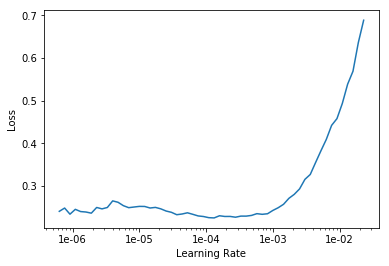

In [12]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.save('stage1-densenet-normal')

In [14]:
import gc 
gc.collect()

6380

# Stage 2

In [15]:
learn.load('stage1-densenet-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,0,0,1,3
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [16]:
learn.fit_one_cycle(10,max_lr = slice(1e-6,5e-4))

In [17]:
learn.save('stage2-densenet-normal')

In [18]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

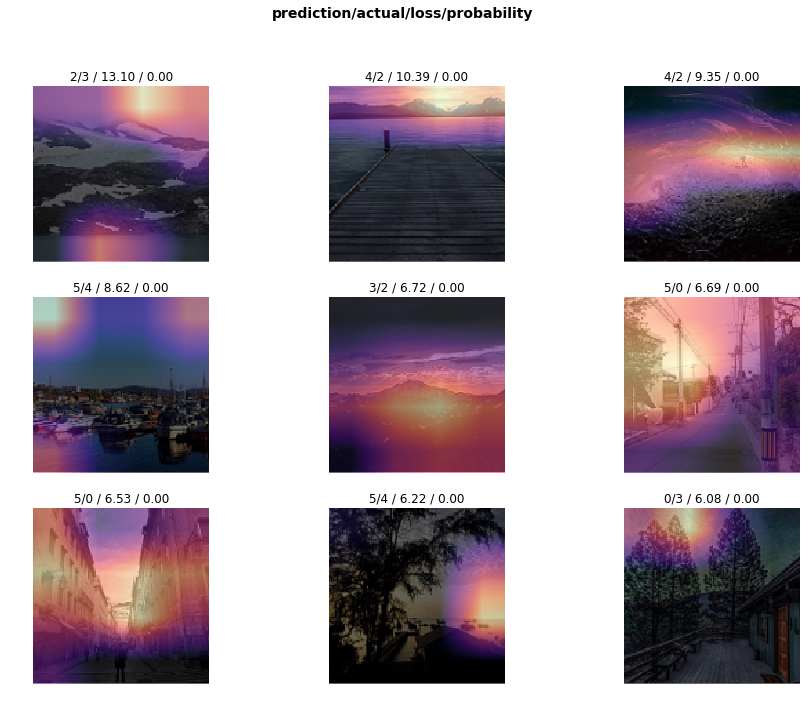

In [19]:
interp.plot_top_losses(9, figsize=(15,11))

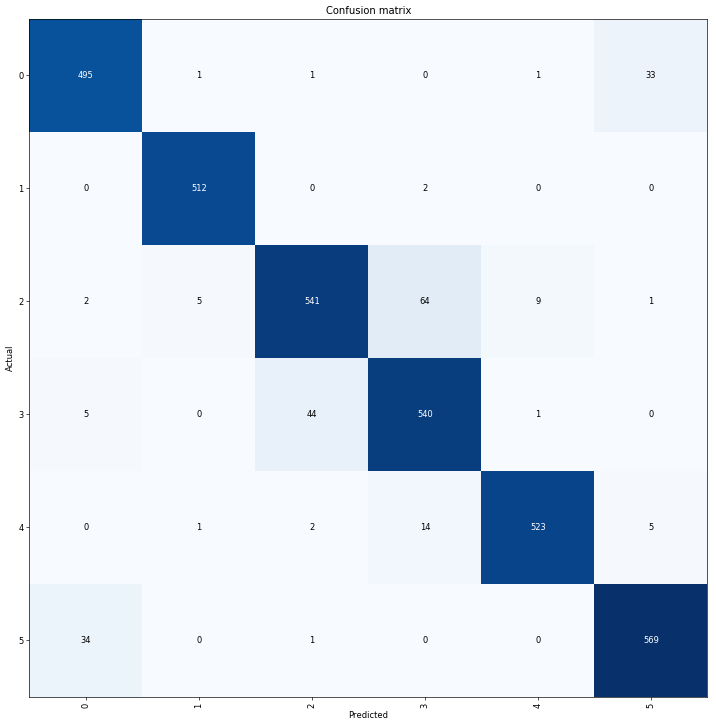

In [20]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [21]:
interp.most_confused(min_val=5)

[(2, 3, 64),
 (3, 2, 44),
 (5, 0, 34),
 (0, 5, 33),
 (4, 3, 14),
 (2, 4, 9),
 (2, 1, 5),
 (3, 0, 5),
 (4, 5, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


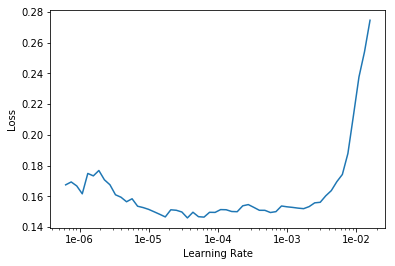

In [22]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
test = pd.read_csv('test.csv')

In [24]:
import gc 
gc.collect()

6555

In [25]:
path='train-scene/train'

In [26]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999989
1      5.jpg      0     0.999658
2      6.jpg      4     0.999670
3     11.jpg      2     0.529248
4     14.jpg      5     0.999362

In [27]:
uncertain = answer.loc[answer['probability']<0.5].count()
print(uncertain)

image_name     28
label          28
probability    28
dtype: int64


In [28]:
answer.to_csv('stage2_densenet_normal.csv')

# Stage 3

In [22]:
learn.load('stage2-densenet_normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,5,2,5,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [23]:
learn.fit_one_cycle(5,max_lr = slice(3e-5,9e-5))

In [24]:
learn.save('stage-3-densenet')

In [25]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

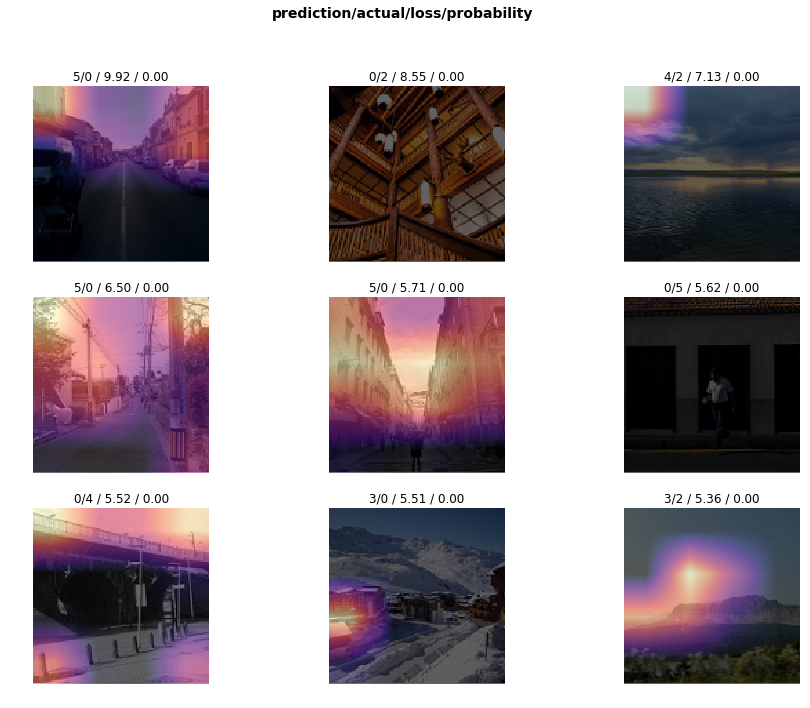

In [28]:
interp.plot_top_losses(9, figsize=(15,11))

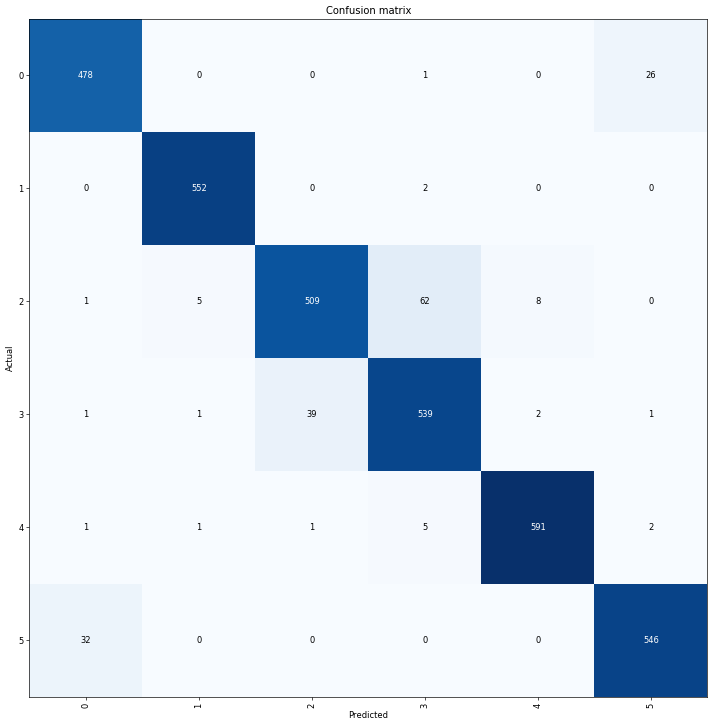

In [29]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [30]:
interp.most_confused(min_val=5)

[(2, 3, 62),
 (3, 2, 39),
 (5, 0, 32),
 (0, 5, 26),
 (2, 4, 8),
 (2, 1, 5),
 (4, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


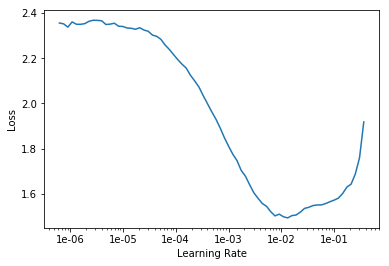

In [31]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [32]:
test = pd.read_csv('test.csv')

In [33]:
import gc 
gc.collect()

6974

In [34]:
path='train-scene/train'

In [35]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      2     0.287165
1      5.jpg      5     0.331877
2      6.jpg      5     0.273970
3     11.jpg      2     0.376281
4     14.jpg      2     0.576744

In [36]:
uncertain = answer.loc[answer['probability']<0.5].count()
print(uncertain)

image_name     6860
label          6860
probability    6860
dtype: int64


In [37]:
answer.to_csv('stage3_densenet.csv')

# ResNet152 Normalized

In [1]:
from fastai.vision import *

In [3]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0))

In [4]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,3,5,0,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

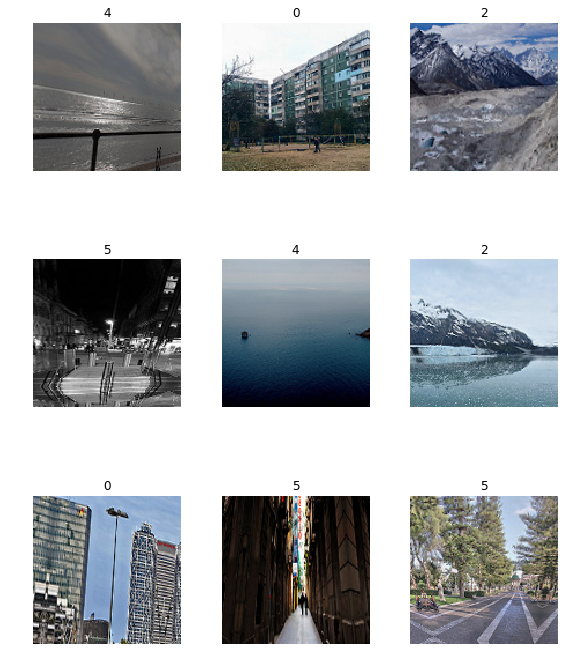

In [41]:
data.show_batch(rows=3, figsize=(8,10))

In [42]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [5]:
learn = cnn_learner(data,models.resnet152,metrics=[error_rate, accuracy])

In [46]:
learn.fit_one_cycle(5)

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

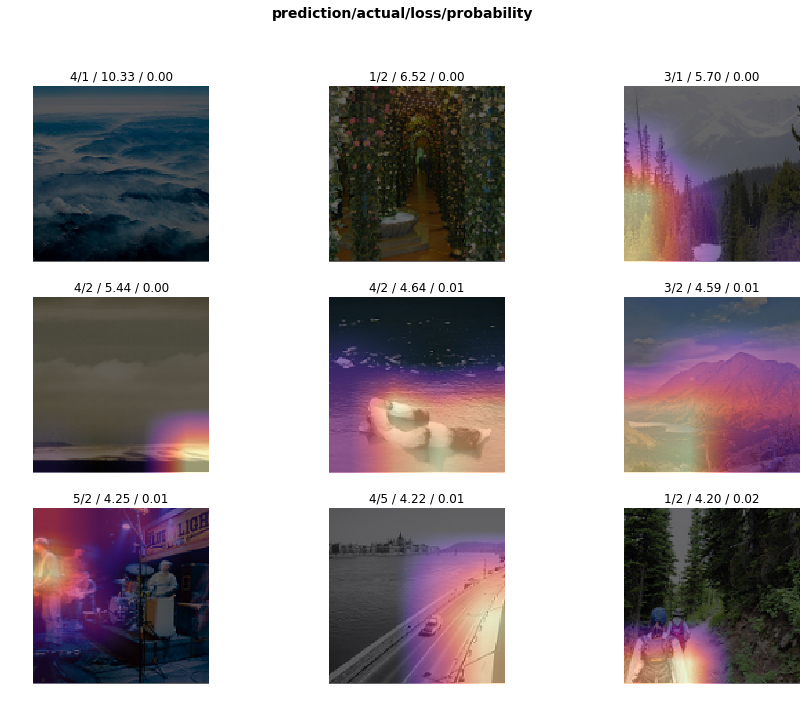

In [48]:
interp.plot_top_losses(9, figsize=(15,11))

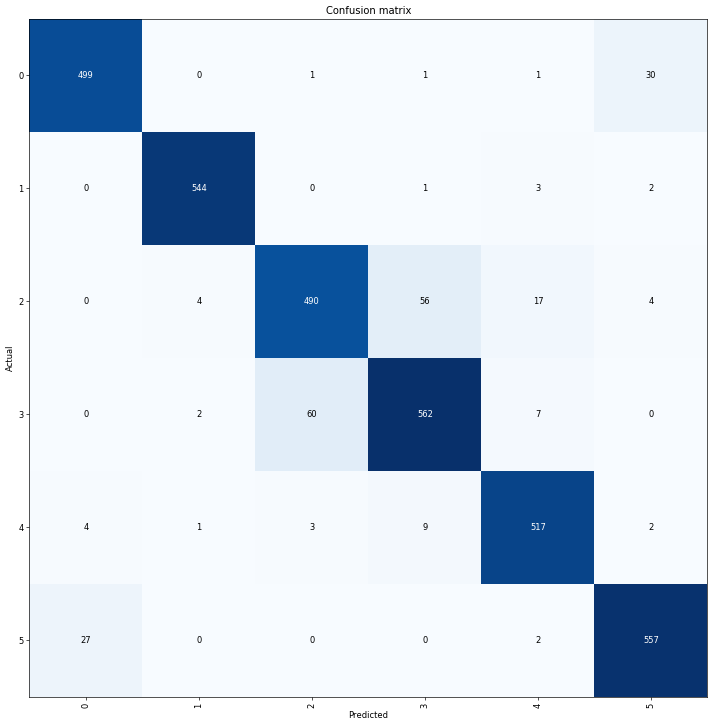

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
interp.most_confused(min_val=5)

[(3, 2, 60),
 (2, 3, 56),
 (0, 5, 30),
 (5, 0, 27),
 (2, 4, 17),
 (4, 3, 9),
 (3, 4, 7)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


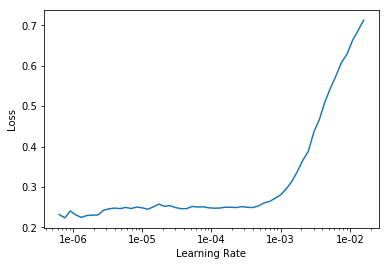

In [51]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.save('stage1-resnet152-normal')

In [33]:
import gc 
gc.collect()

945

# Stage 2

In [6]:
learn.load('stage1-resnet152-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,5,2,5,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [54]:
learn.fit_one_cycle(10,max_lr = slice(1e-6,1e-4))

In [55]:
learn.save('stage-2-resnet152-normal')

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

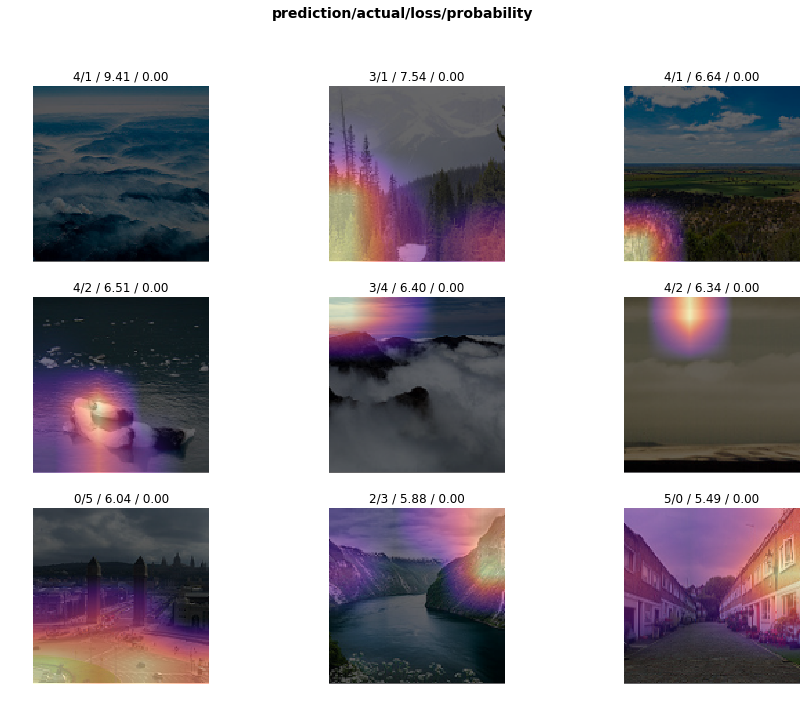

In [57]:
interp.plot_top_losses(9, figsize=(15,11))

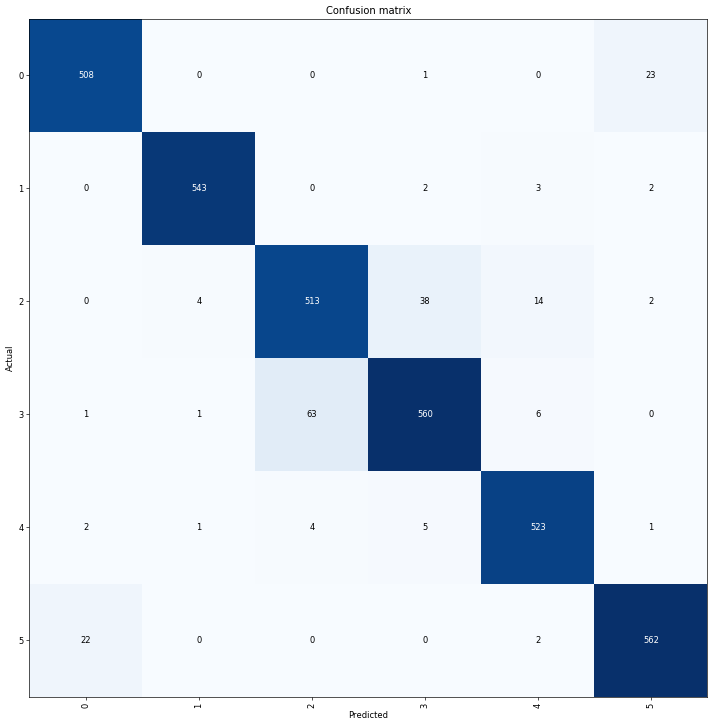

In [58]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [59]:
interp.most_confused(min_val=5)

[(3, 2, 63),
 (2, 3, 38),
 (0, 5, 23),
 (5, 0, 22),
 (2, 4, 14),
 (3, 4, 6),
 (4, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


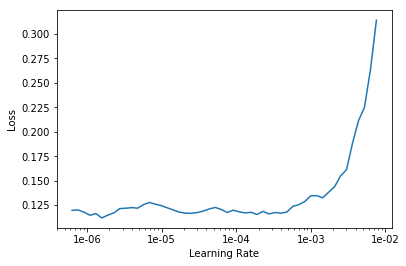

In [60]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
test = pd.read_csv('test.csv')

In [62]:
import gc 
gc.collect()

6561

In [63]:
path='train-scene/train'

In [64]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999533
1      5.jpg      0     0.998755
2      6.jpg      4     0.999852
3     11.jpg      2     0.886517
4     14.jpg      5     0.995437

In [68]:
uncertain = answer.loc[answer['probability']<0.5]
print(uncertain)

     image_name  label  probability
347    1123.jpg      2     0.429991
419    1364.jpg      0     0.453251
813    2734.jpg      4     0.422350
814    2737.jpg      2     0.411909
1074   3668.jpg      4     0.482490
1565   5110.jpg      2     0.497628
1750   5796.jpg      5     0.498379
1827   6051.jpg      3     0.490466
2280   7606.jpg      4     0.313523
2665   8858.jpg      2     0.414039
2712   9024.jpg      3     0.373042
3059  10159.jpg      0     0.451684
3230  10769.jpg      0     0.499761
3683  12351.jpg      3     0.498589
3687  12356.jpg      5     0.382800
3713  12453.jpg      4     0.451348
4104  13724.jpg      3     0.498525
4242  14201.jpg      0     0.396003
4254  14241.jpg      1     0.481035
4414  14774.jpg      2     0.498766
4446  14890.jpg      3     0.438827
4520  15112.jpg      1     0.480187
5091  17023.jpg      2     0.443082
5318  17710.jpg      3     0.488139
5662  18924.jpg      5     0.307389
5669  18956.jpg      0     0.341425
6166  20542.jpg      2     0

In [66]:
answer.to_csv('stage2_resnet152_normal.csv')

# Cleaning the data (doesn't work) 

In [6]:
learn.load('stage-2-resnet152-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,4,0,1,5
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
3,3,5,0,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [6]:
import gc
gc.collect()

0

In [7]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

In [10]:
#from fastai.widgets import *


In [11]:
#ds, idxs = DatasetFormatter().from_toplosses(learn, ds_type=DatasetType.Valid)

In [12]:
#ImageCleaner(ds, idxs, path)

# VGG16

In [13]:
path = "train_data"
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0.5)
data = (ImageList.from_csv(path, csv_name = 'train.csv') 
        .split_by_rand_pct()              
        .label_from_df()            
        .add_test_folder(test_folder = 'data_test')              
        .transform(tfms, size=224)
        .databunch(num_workers=0))

In [14]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
0,5,0,4,1
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
4,3,3,1,3
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data

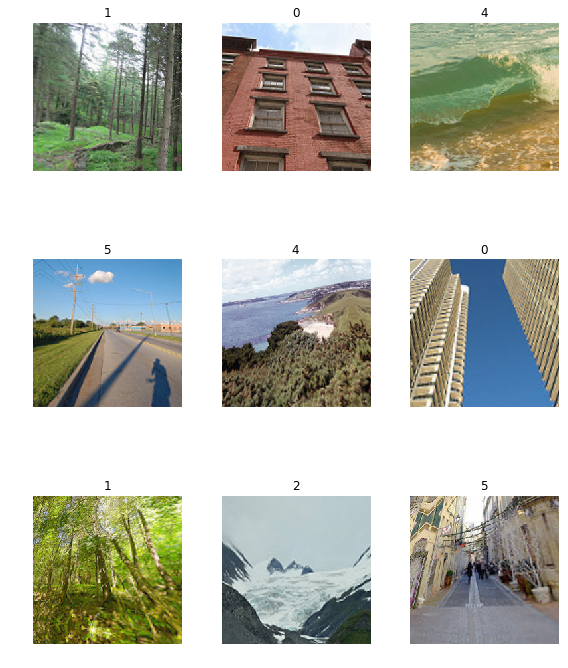

In [15]:
data.show_batch(rows=3, figsize=(8,10))

In [16]:
print(data.classes)

[0, 1, 2, 3, 4, 5]


In [21]:
help(unet_learner)

Help on function unet_learner in module fastai.vision.learner:

unet_learner(data:fastai.basic_data.DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True, norm_type:Union[fastai.layers.NormType, NoneType]=<enum 'NormType'>, split_on:Union[Callable, Collection[Collection[torch.nn.modules.module.Module]], NoneType]=None, blur:bool=False, self_attention:bool=False, y_range:Union[Tuple[float, float], NoneType]=None, last_cross:bool=True, bottle:bool=False, cut:Union[int, Callable]=None, **learn_kwargs:Any) -> fastai.basic_train.Learner
    Build Unet learner from `data` and `arch`.



In [23]:
learn = cnn_learner(data,models.vgg16_bn,metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to C:\Users\rohit/.torch\models\vgg16_bn-6c64b313.pth
553507836it [03:49, 2408919.97it/s]


In [25]:
learn.fit_one_cycle(5)

RuntimeError: CUDA out of memory. Tried to allocate 36.75 MiB (GPU 0; 8.00 GiB total capacity; 6.00 GiB already allocated; 3.97 MiB free; 67.13 MiB cached)

In [47]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

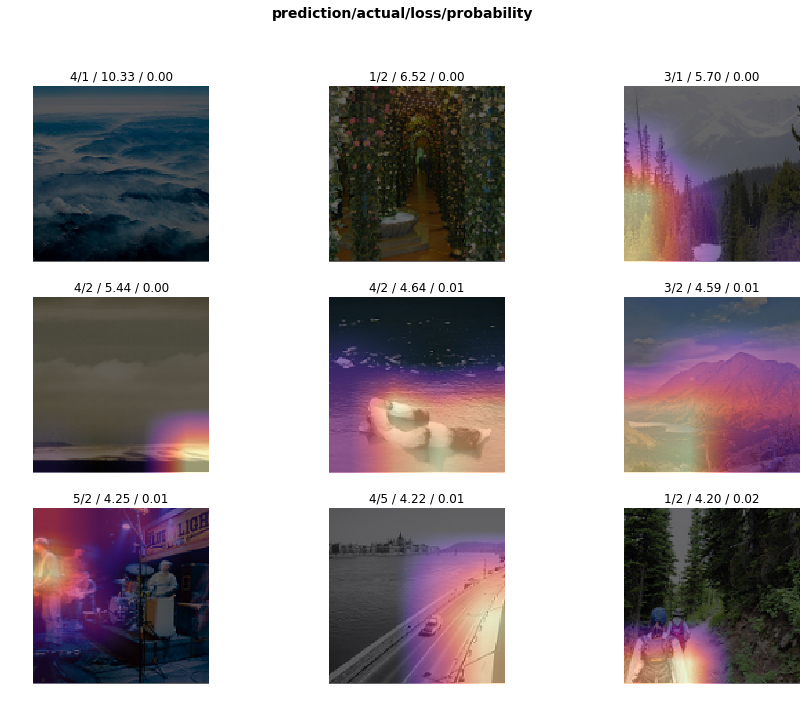

In [48]:
interp.plot_top_losses(9, figsize=(15,11))

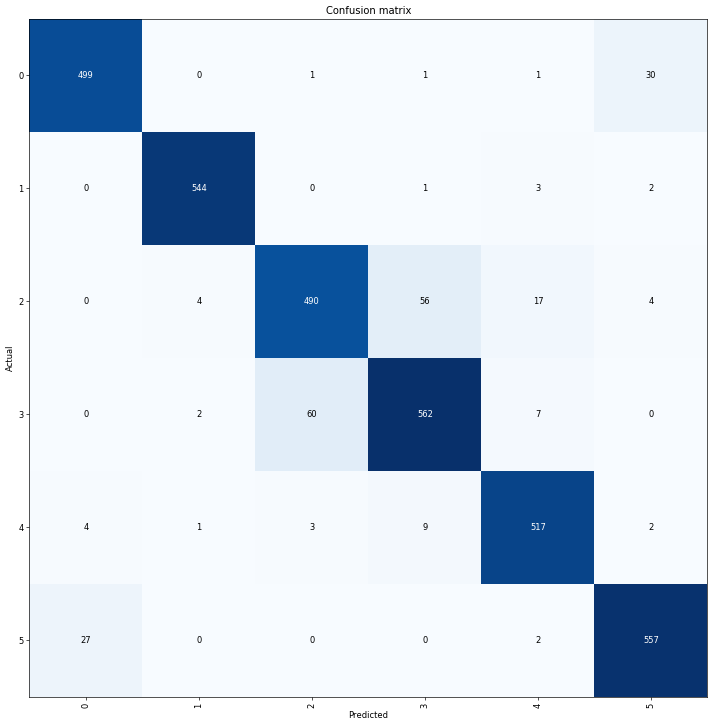

In [49]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [50]:
interp.most_confused(min_val=5)

[(3, 2, 60),
 (2, 3, 56),
 (0, 5, 30),
 (5, 0, 27),
 (2, 4, 17),
 (4, 3, 9),
 (3, 4, 7)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


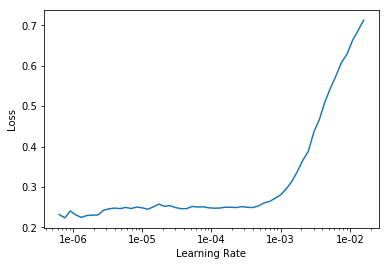

In [51]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [52]:
learn.save('stage1-vgg-normal')

In [33]:
import gc 
gc.collect()

945

# Stage 2

In [6]:
learn.load('stage1-vgg-normal')

Learner(data=ImageDataBunch;

Train: LabelList (13628 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,4,5,0,4
Path: train_data;

Valid: LabelList (3406 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,5,2,5,2
Path: train_data;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: train_data, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_run

In [54]:
learn.fit_one_cycle(10,max_lr = slice(1e-6,1e-4))

In [55]:
learn.save('stage-2-vgg-normal')

In [56]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

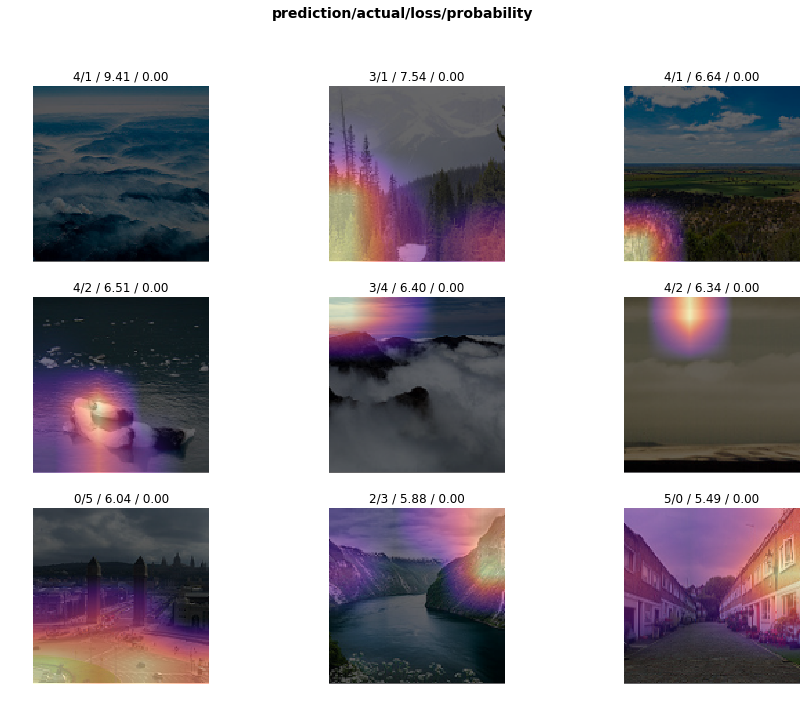

In [57]:
interp.plot_top_losses(9, figsize=(15,11))

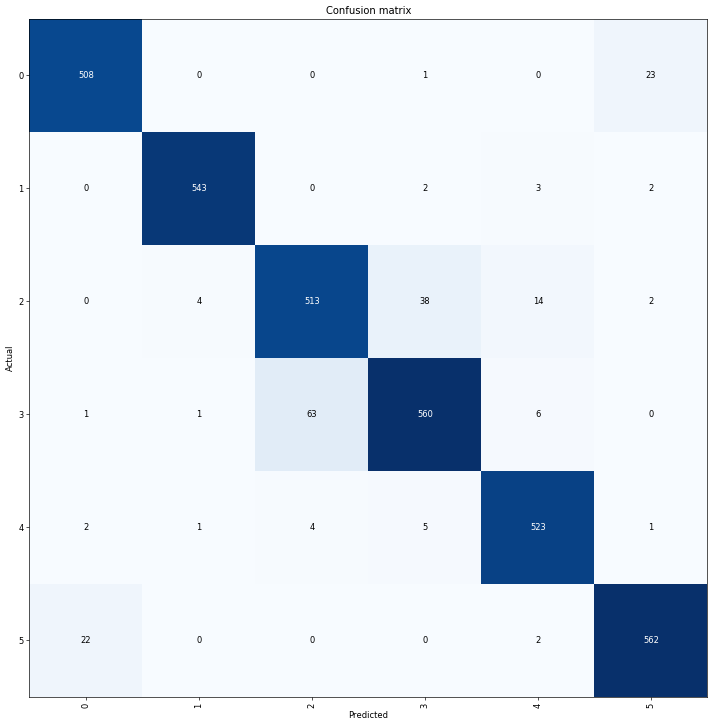

In [58]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [59]:
interp.most_confused(min_val=5)

[(3, 2, 63),
 (2, 3, 38),
 (0, 5, 23),
 (5, 0, 22),
 (2, 4, 14),
 (3, 4, 6),
 (4, 3, 5)]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


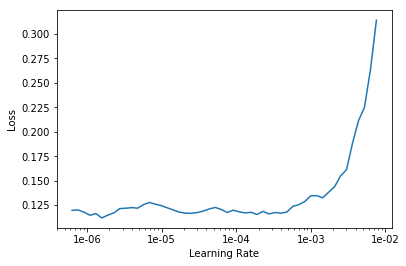

In [60]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [61]:
test = pd.read_csv('test.csv')

In [62]:
import gc 
gc.collect()

6561

In [63]:
path='train-scene/train'

In [64]:
images = []
prediction = []
probability = []
for i in test['image_name']:
  images.append(i)
  link = str(path)+'/'+i
  img = open_image(link)
  pred_class,pred_idx,outputs = learn.predict(img)
  prediction.append(pred_class.obj)
  probability.append(outputs.abs().max().item())
answer = pd.DataFrame({'image_name':images,'label':prediction,'probability':probability})
answer.head()
#answer.to_csv('submission.csv')

image_name  label  probability
0      3.jpg      5     0.999533
1      5.jpg      0     0.998755
2      6.jpg      4     0.999852
3     11.jpg      2     0.886517
4     14.jpg      5     0.995437

In [68]:
uncertain = answer.loc[answer['probability']<0.5]
print(uncertain)

     image_name  label  probability
347    1123.jpg      2     0.429991
419    1364.jpg      0     0.453251
813    2734.jpg      4     0.422350
814    2737.jpg      2     0.411909
1074   3668.jpg      4     0.482490
1565   5110.jpg      2     0.497628
1750   5796.jpg      5     0.498379
1827   6051.jpg      3     0.490466
2280   7606.jpg      4     0.313523
2665   8858.jpg      2     0.414039
2712   9024.jpg      3     0.373042
3059  10159.jpg      0     0.451684
3230  10769.jpg      0     0.499761
3683  12351.jpg      3     0.498589
3687  12356.jpg      5     0.382800
3713  12453.jpg      4     0.451348
4104  13724.jpg      3     0.498525
4242  14201.jpg      0     0.396003
4254  14241.jpg      1     0.481035
4414  14774.jpg      2     0.498766
4446  14890.jpg      3     0.438827
4520  15112.jpg      1     0.480187
5091  17023.jpg      2     0.443082
5318  17710.jpg      3     0.488139
5662  18924.jpg      5     0.307389
5669  18956.jpg      0     0.341425
6166  20542.jpg      2     0

In [66]:
answer.to_csv('stage2_vgg_normal.csv')